## Neural network potential force fitting example - 1D chain of atoms.
This example involves fitting a neural network potential to a target potential for a 1D chain of atoms. The target potential is defined by us - a simple harmonic potential. This target potential will serve as our "ab initio" potential in this example.

**This is a valuable example for realistic/3D force fitting because:**
- Neural network architectures and code are the same.
- Simple models are solved by hand to verify force calculation.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch import tensor

## Training configs.
Generate a 1D lattice with randomly displaced atoms like:
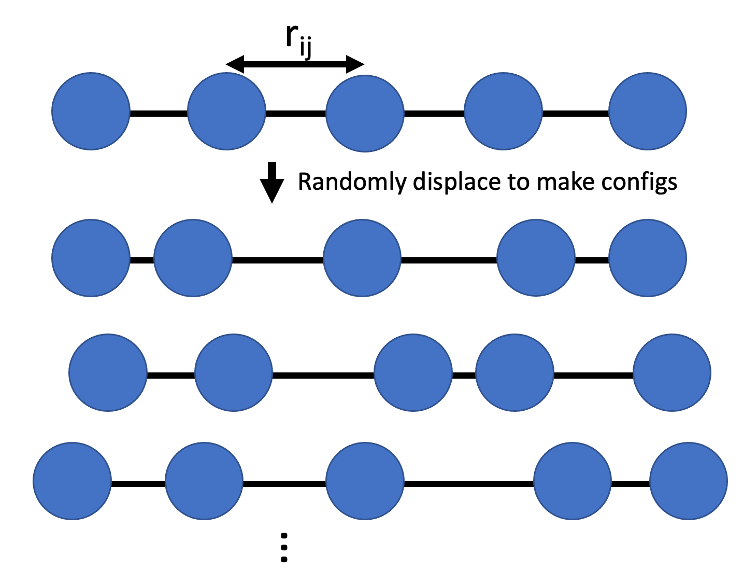

In [143]:
"""
Define 1D configurations of atoms.
These will be displacements of a 1D chain, where the equilibrium distance is "1".
"""
natoms = 5
nconfigs = 5
rc = 1.5

# Descriptor params.
# Each row is a different descriptor parameter set, so number of rows = number of descriptors. 
dparams = [[0.1,0.5],
           [0.1,2.0],
           [0.01,0.01],
           [0.01,5.0],
           [0.03,5.0],
           [0.03,10.0],
           [0.05, 3.0],
           [0.05, 6.0],
           [0.2,2.0],
           [0.2,3.0]]
dparams = np.array(dparams)
nd = np.shape(dparams)[0] # number of descriptors

# Define indices upon which to contract per-atom energies
indices = []
for m in range(0,nconfigs):
    for i in range(0,natoms):
        indices.append(m)
indices = torch.tensor(indices, dtype=torch.int64)

# Number of atoms per config is needed for future energy calculation.
num_atoms = natoms*torch.ones(nconfigs,dtype=torch.int32)

# Torch params
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
# Box size for 1D system of atoms
x_size = float(natoms)
x_rsize = 1.0 / x_size;

x0 = []
for i in range(0,natoms):
    x0.append(float(i))
x0 = np.array(x0)

# Define all configs
x_all = [x0]
for m in range(0,nconfigs-1):
    x_tmp = []
    for i in range(0,natoms):
        x_tmp.append(np.random.normal(loc=x0[i],scale=0.1*1))
    x_all.append(x_tmp)
x_all =  np.array(x_all)

## Calculate descriptors D & descriptor derivatives dD/dR.
We will use the Behler-Parinello (BP) descriptors for describing atomic environments:
$$
D_i = \sum_{j \neq i} e^{-\eta (r_{ij} - r_s)^2}f_c(r_{ij})
$$
These descriptors are inputs to the neural network. 


We also calculate descriptor derivatives using the neighborlist:
$$
\frac{\partial D_{jk}}{\partial r_i}
$$

In [144]:
"""
Function to calculate the cutoff function used in the BP descriptors.
Input: rij - distance between two atoms.
Returns a single value of the cutoff function evaluated at a particular rij. 
"""
def fc(rij):
    value = 0.5*(np.cos((np.pi*rij)/rc) + 1)
    return value

"""
Function to calculate descriptors for all atoms.
Input: x - positions of atoms in config.
Returns list of descriptors for all atoms in the config, with shape (natoms,nd)
"""
def calc_descriptors(x):
    d = np.zeros([natoms,nd])
    dDdR = np.zeros([natoms,nd*2])
    for i in range(0,natoms):
        d_tmp = 0.0
        jj = 0 # a neighbor index for i 
        for j in range(0,natoms):
            if (i!=j):
                xij = x[j]-x[i]
                xij -= x_size * round(xij * x_rsize);
                rij = abs(xij)
                if (rij<1.5):
                    for k in range(0,nd):
                        eta = dparams[k,0]
                        rs = dparams[k,1]
                        d[i,k] += np.exp(-1.0*eta*(rij-rs)**2)*fc(rij)
                        # Descriptor derivatives
                        drdri = -1.*xij/abs(xij)
                        # First term in the chain rule expression for dD/dRi
                        first_term = np.exp(-1.0*eta*(rij-rs)**2)*(-1.0*eta*2*(rij-rs)*drdri)*fc(rij)
                        # Second term in the chain rule expression for dD/dRi
                        dfcdri = ((-1.0*np.pi)/(2*rc))*drdri*np.sin((np.pi*abs(xij))/rc)
                        second_term = np.exp(-1.0*eta*(rij-rs)**2)*dfcdri 
                        dDdR[i,nd*jj + k] = first_term + second_term
                    jj = jj + 1
    return (d,dDdR)

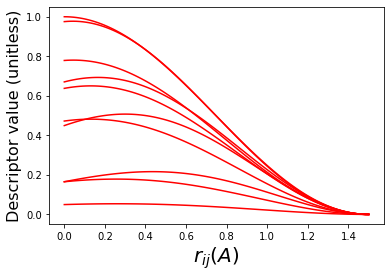

In [145]:
"""
Plot descriptors.
Visualize what the descriptors look like.
"""
def visualize_descriptors():
    rij = np.linspace(0,rc,100)
    functions = []
    for k in range(0,nd):
        d_tmp = np.exp(-1.0*dparams[k,0]*(rij-dparams[k,1])**2)*fc(rij)
        plt.plot(rij, d_tmp, 'r')
    plt.xlabel(r'$r_{ij} (A)$', fontsize=20)
    plt.ylabel("Descriptor value (unitless)", fontsize=16)
    plt.show()
visualize_descriptors()

## Define target potential to fit to.

The target potential is a harmonic potential:
$$ 
U_{ij} = kr_{ij}^2
$$

In [147]:
"""
Define the 2-body potential that we will fit the neural network potential to.
Input: x - positions of atoms in config.
Return forces and energy for a single config.
"""
def potential(x):
    etot = 0.
    f = np.zeros(natoms)
    for i in range(0,natoms):
        ei = 0.0
        for j in range(0,natoms):
            if (i!=j):
                xij = x[j]-x[i]
                xij -= x_size * round(xij * x_rsize);
                rij = abs(xij)
                if (rij<1.5):
                    ei += (rij-1.)**2
                    f[i] += 2.0*(rij-1)*((xij)/rij)
        etot += ei
        
    return (etot,f)

## Generate training data.
This includes:
- Energies
- Forces
- Descriptors
- Descriptor derivatives $\frac{\partial D_{jk}}{\partial r_i}$
- **Neighbor lists**

In [148]:
"""
Loop through all configs (training data) and calculate:
energies
forces
descriptors
descriptor derivatives dD/dR
tags (useful for calculating model forces later)
neighlists
    neighlists[m] are the neighbors of atoms in config m
    neighlists[m,i] are the neighbors of atom i in config m
    neighlists[m,i,j] is the jth neighbor of atom i in config m
"""
targets = torch.zeros(nconfigs)
target_forces = torch.zeros(nconfigs*natoms)
descriptors = []
descriptor_derivatives = []
tags = []
neighlists = []
for m in range(0,nconfigs):
    (pe,f) = potential(x_all[m,:])
    targets[m] = pe
    tags_m = []
    neighlist_m = []
    for i in range(0,natoms):
        target_forces[m*natoms+i] = f[i]
        tags_m.append(i)
        neighlist_mi = []
        for j in range(0,natoms):
            if (i!=j):
                xij = x_all[m,j]-x_all[m,i]
                xij -= x_size * round(xij * x_rsize);
                rij = abs(xij)
                if (rij<1.5):
                    neighlist_mi.append(j)
        neighlist_m.append(neighlist_mi)
    neighlists.append(neighlist_m)
    tags.append(tags_m)
    (d_tmp, dDdR_tmp) = calc_descriptors(x_all[m,:])
    descriptors.append(d_tmp)
    descriptor_derivatives.append(dDdR_tmp)
    
neighlists = np.array(neighlists).astype(int)
tags = np.array(tags).astype(int)
# Make descriptors numpy arrays.
descriptors = np.array(descriptors)
descriptor_derivatives = np.array(descriptor_derivatives)
# Concatenate descriptors to have configs stacked on each other.
descriptors = np.concatenate(descriptors,axis=0)
descriptor_derivatives = np.concatenate(descriptor_derivatives,axis=0)
# Make descriptors torch tensors and add gradient requirement.
descriptors = torch.from_numpy(descriptors).float().requires_grad_()
descriptor_derivatives = torch.from_numpy(descriptor_derivatives).float().requires_grad_()


## Build network model.


In [90]:
"""
Define the network parameters
"""
#layer_sizes = ['num_desc', '10', '8', '6', '1'] # FitSNAP style
layer_sizes = [nd, 16, 8, 1]


### Using FitSNAP functions.

In [149]:
def create_torch_network(layer_sizes):
    """
    Creates a pytorch network architecture from layer sizes.
    This also performs standarization in the first linear layer.
    This only supports softplus as the nonlinear activation function.

        Parameters:
            layer_sizes (list of ints): Size of each network layers

        Return:
            Network Architecture of type neural network sequential

    """
    layers = []
    try:
        
        layers.append(torch.nn.Linear(layer_sizes[0], layer_sizes[0]))
        for i, layer in enumerate(layer_sizes):
            layers.append(torch.nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            layers.append(torch.nn.Softplus())
    except IndexError:
        layers.pop()
    
    return torch.nn.Sequential(*layers)

network_architecture = create_torch_network(layer_sizes)

## FitSNAP network model class.
Added force calculation:
$$
F_i = \sum_j \sum_k \ \frac{\partial D_{jk}}{\partial r_i} \frac{\partial E_{j}}{\partial D_{jk}}
$$

Where:
- Descriptor derivatives $\frac{\partial D_{jk}}{\partial r_i}$ are stored from previous calculations.
- Model derivatives $\frac{\partial E_{j}}{\partial D_{jk}}$ are calculated PyTorch autograd.
- Previously computed neighborlists help solve this sum properly.

In [153]:
"""
Define the model
"""
class FitTorch(torch.nn.Module):
    """
    FitSNAP PyTorch Neural Network Architecture Model
    Currently only fits on energies
    """

    def __init__(self, network_architecture, descriptor_count, n_elements=1):
        """
        Saves lammps ready pytorch model.

            Parameters:
                network_architecture : A nn.Sequential network architecture
                descriptor_count (int): Length of descriptors for an atom
                n_elements (int): Number of differentiable atoms types

        """
        super().__init__()
        self.network_architecture = network_architecture
        self.desc_len = descriptor_count
        self.n_elem = n_elements
        
    def forward(self, x, x_derivatives, indices, atoms_per_structure):
        """
        Saves lammps ready pytorch model.

            Parameters:
                x (tensor of floats): Array of descriptors
                x_derivatives (tensor of floats): Array of descriptor derivatives
                indices (tensor of ints): Array of indices upon which to contract per atom energies
                atoms_per_structure (tensor of ints): Number of atoms per configuration

        """
        print(x_derivatives.size())
        nbatch = int(x.size()[0]/natoms)
        print(f"{nbatch} configs in this batch")
        
        # Calculate energies
        predicted_energy_total = torch.zeros(atoms_per_structure.size())
        predicted_energy_total.index_add_(0, indices, self.network_architecture(x).squeeze())
        
        # Calculate forces
        dEdD = torch.autograd.grad(self.network_architecture(x), x, grad_outputs=torch.ones_like(self.network_architecture(x)))
        predicted_forces = torch.zeros(nconfigs*natoms)
        # Loop over all configs given by number of rows in descriptors array
        for m in range(0,nbatch):
            for i in range(0,natoms):
                # Loop over neighbors of i
                numneighs_i = len(neighlists[m,i])
                for jj in range(0,numneighs_i):
                    j = neighlists[m,i,jj]
                    jtag = tags[m,j]
                    for k in range(0,nd):
                        predicted_forces[natoms*m + i] -= x_derivatives[natoms*m + i,(jj*nd)+k]*dEdD[0][natoms*m + jtag,k]
        
        return (predicted_energy_total, predicted_forces)

    def import_wb(self, weights, bias):
        """
        Imports weights and bias into FitTorch model

            Parameters:
                weights (list of numpy array of floats): Network weights at each layer
                bias (list of numpy array of floats): Network bias at each layer

        """

        assert len(weights) == len(bias)
        imported_parameter_count = sum(w.size + b.size for w, b in zip(weights, bias))
        combined = [None] * (len(weights) + len(bias))
        combined[::2] = weights
        combined[1::2] = bias

        assert len([p for p in self.network_architecture.parameters()]) == len(combined)
        assert sum(p.nelement() for p in self.network_architecture.parameters()) == imported_parameter_count

        state_dict = self.state_dict()
        for i, key in enumerate(state_dict.keys()):
            state_dict[key] = torch.tensor(combined[i])
        self.load_state_dict(state_dict)
        
"""
Create the model.
"""
model = FitTorch(network_architecture, nd)
print(model)

FitTorch(
  (network_architecture): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=16, bias=True)
    (2): Softplus(beta=1, threshold=20)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): Softplus(beta=1, threshold=20)
    (5): Linear(in_features=8, out_features=1, bias=True)
  )
)


## Training

In [154]:
"""
Define training objects
"""
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)


In [155]:
"""
Train.
Energy fitting:
    Might have to run with 1000-2000 epochs or more, using lr=5e-3.
    For great looking energy error, should have loss ~ 1e-4
    Energy fitting works well... Not so much with forces. Need to check force calculation is correct. 

"""

for epoch in range(10):
    (energies, forces) = model(descriptors, descriptor_derivatives, indices, num_atoms)
    energies = energies.to(device)
    forces = forces.to(device)
    loss = loss_function(energies/num_atoms, targets/num_atoms) + 0.1*loss_function(forces, target_forces)
    if (epoch % 10 == 0):
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

torch.Size([25, 20])
5 configs in this batch
epoch: 1, loss = 0.0206
torch.Size([25, 20])
5 configs in this batch
torch.Size([25, 20])
5 configs in this batch
torch.Size([25, 20])
5 configs in this batch
torch.Size([25, 20])
5 configs in this batch
torch.Size([25, 20])
5 configs in this batch
torch.Size([25, 20])
5 configs in this batch
torch.Size([25, 20])
5 configs in this batch
torch.Size([25, 20])
5 configs in this batch
torch.Size([25, 20])
5 configs in this batch


torch.Size([25, 20])
5 configs in this batch


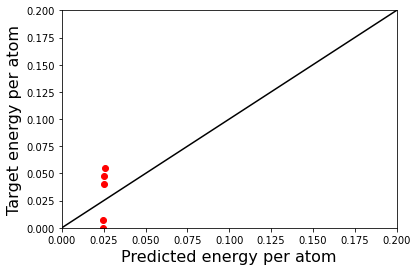

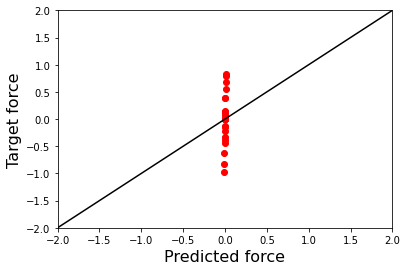

In [156]:
# Plot
(energies, forces) = model(descriptors, descriptor_derivatives, indices,num_atoms)
energies = energies.detach().numpy()

# Energies
lims = [0.0,0.2]
plt.plot(energies/natoms, targets.numpy()/natoms, 'ro')
plt.plot(lims, lims, 'k-')
plt.xlabel("Predicted energy per atom", fontsize=16)
plt.ylabel("Target energy per atom", fontsize=16)
plt.xlim(0.0, 0.2)
plt.ylim(0.0,0.2)
plt.show()
#"""

# Forces 
lims = [-2,2]
plt.plot(forces.detach().numpy(), target_forces.numpy(), 'ro')
plt.plot(lims,lims,'k-')
plt.xlabel("Predicted force", fontsize=16)
plt.ylabel("Target force", fontsize=16)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

0 0
torch.Size([5, 20])
1 configs in this batch
torch.Size([5, 20])
1 configs in this batch
torch.Size([5, 20])
1 configs in this batch
Model:
 Actual: 1.2223608791828156e-09 
 FD: [-5.215406e-05]
-------
0 1
torch.Size([5, 20])
1 configs in this batch
torch.Size([5, 20])
1 configs in this batch
torch.Size([5, 20])
1 configs in this batch
Model:
 Actual: -1.2223608791828156e-09 
 FD: [-3.7252903e-05]
-------
0 2
torch.Size([5, 20])
1 configs in this batch
torch.Size([5, 20])
1 configs in this batch
torch.Size([5, 20])
1 configs in this batch
Model:
 Actual: -1.2223608791828156e-09 
 FD: [-3.7252903e-05]
-------
0 3
torch.Size([5, 20])
1 configs in this batch
torch.Size([5, 20])
1 configs in this batch
torch.Size([5, 20])
1 configs in this batch
Model:
 Actual: -1.2223608791828156e-09 
 FD: [-3.7252903e-05]
-------
0 4
torch.Size([5, 20])
1 configs in this batch
torch.Size([5, 20])
1 configs in this batch
torch.Size([5, 20])
1 configs in this batch
Model:
 Actual: 1.2223608791828156e-09

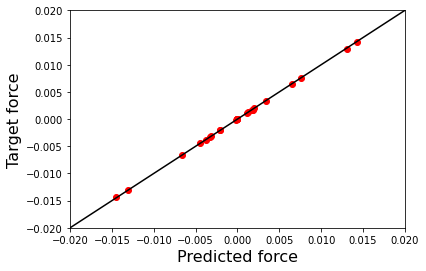

In [164]:
"""
Verify force calculation with finite difference.
For a single config of atoms, calculate F = [ E(r+h)-E(r-h) ]/2h
"""
f_actual_all = []
f_fd_all = []
nconfigs=5
for m in range(0,nconfigs):
    for atomindx in range(0,natoms):
        print(f"{m} {atomindx}")
        #m = 2
        #atomindx = 0
        #print(f"Testing m={m} and atomindx={atomindx}")
        x = x_all[m,:]
        #print("targets ------------")
        #print("positions:")
        #print(x)
        #print("energy:")
        #print(targets[m])
        #print("forces:")
        for i in range(0,natoms):
            fi = target_forces[m*natoms+i]
            #print(fi)
        #print("--------------------")


        (pe, f) = potential(x)
        #print("potential(x):")
        #print(pe)
        #print(f)
        #print("--------------------")

        # Finite difference tests
        h = 0.001
        x0 = x_all[m,:]

        # Plus
        x = x0
        x[atomindx] += h
        (pe1,f1) = potential(x)
        #print(pe)
        #print(f)

        # Minus
        x = x0
        x[atomindx] -= h
        (pe2,f2) = potential(x)
        #print(pe)
        #print(f)

        # Derivative
        f_fd = -(pe1-pe2)/(2*h)
        #print("Potential:")
        #print(f_fd)
        #print("-------")

        """
        Model derivatives
        """
        # Now, nconfigs=1
        #nconfigs = 1
        # Define indices upon which to contract per-atom energies
        indices = []
        for mm in range(0,1):
            for ii in range(0,natoms):
                indices.append(mm)
        indices = torch.tensor(indices, dtype=torch.int64)
        #print(indices)

        # Number of atoms per config is needed for future energy calculation.
        num_atoms = natoms*torch.ones(1,dtype=torch.int32)
        #print(num_atoms)

        # Actual force
        (descriptors, descriptor_derivatives) = calc_descriptors(x)
        # Make descriptors torch tensors and add gradient requirement.
        descriptors = torch.from_numpy(descriptors).float().requires_grad_()
        descriptor_derivatives = torch.from_numpy(descriptor_derivatives).float().requires_grad_()
        #print(descriptor_derivatives)
        (energies, forces) = model(descriptors, descriptor_derivatives, indices, num_atoms)
        pe_model = energies.to(device)
        forces_model = forces.to(device)

        # Plus
        x = x0
        x[atomindx] += h

        (descriptors, descriptor_derivatives) = calc_descriptors(x)
        # Make descriptors torch tensors and add gradient requirement.
        descriptors = torch.from_numpy(descriptors).float().requires_grad_()
        descriptor_derivatives = torch.from_numpy(descriptor_derivatives).float().requires_grad_()
        #print(descriptor_derivatives)
        (energies, forces) = model(descriptors, descriptor_derivatives, indices, num_atoms)
        pe1 = energies.to(device)
        f1 = forces.to(device)

        # Minus
        x = x0
        x[atomindx] -= h

        (descriptors, descriptor_derivatives) = calc_descriptors(x)
        # Make descriptors torch tensors and add gradient requirement.
        descriptors = torch.from_numpy(descriptors).float().requires_grad_()
        descriptor_derivatives = torch.from_numpy(descriptor_derivatives).float().requires_grad_()
        (energies, forces) = model(descriptors, descriptor_derivatives, indices, num_atoms)
        pe2 = energies.to(device)
        f2 = forces.to(device)

        # Derivative
        f_fd_model = -(pe1-pe2)/(2*h)

        print("Model:")
        print(f" Actual: {forces_model[atomindx].detach().numpy()} ")
        print(f" FD: {f_fd_model.detach().numpy()}")
        print("-------")
        
        f_actual_all.append(forces_model[atomindx].detach().numpy())
        f_fd_all.append(f_fd_model.detach().numpy())
        
f_actual_all = np.array(f_actual_all)
f_fd_all = np.array(f_fd_all)

# Plot model vs. FD
lim = 0.02
lims = [-lim,lim]
plt.plot(f_fd_all, f_actual_all, 'ro')
plt.plot(lims,lims,'k-')
plt.xlabel("Predicted force", fontsize=16)
plt.ylabel("Target force", fontsize=16)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.show()
